
Import Libraries and Check CUDA Availability
---



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ast
import torch.utils.data as data
from collections import defaultdict, Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# Training parameters
num_classes = 36
num_sensors = 5
sequence_length = 10
batch_size = 32
train_loop_enable =0


Import and Visualize Dataset
---



In [3]:
import ast
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV
csv_file_path = "Preprocessing_and_analysis_of_the_dataset/data_v4.csv"
df = pd.read_csv(csv_file_path)

# Separate feature columns (x1 to x5) and target columns (y1, y2)
x_data = df[['x1', 'x2', 'x3', 'x4', 'x5']]
y_data = df[['y1', 'y2']]

# Convert feature data to PyTorch tensors
x_train = [
    torch.tensor(
        [ast.literal_eval(val) for val in row.values], dtype=torch.float32
    )
    for _, row in x_data.iterrows()
]
X_train = torch.stack(x_train).to(device)  # Shape: [batch_size, num_features, sequence_length]

# No need to permute X_train because it already has the correct shape [batch_size, num_features, sequence_length]

# Convert target data (y1, y2) to PyTorch tensors
y_train = [
    torch.tensor(
        [ast.literal_eval(val) for val in row.values], dtype=torch.float32
    )
    for _, row in y_data.iterrows()
]
Y_train = torch.stack(y_train)  # Shape: [batch_size, num_targets, sequence_length]

# # Permute Y_train to get the shape [batch_size, sequence_length, num_targets]
# Y_train = Y_train.permute(0, 2, 1)  # Hoán vị trục 1 và trục 2

# Verify data shapes
print("Kích thước của X_train:", X_train.shape)  # Should be [batch_size, num_features, sequence_length]
print("Kích thước của Y_train:", Y_train.shape)  # Should be [batch_size, num_targets, sequence_length]


Kích thước của X_train: torch.Size([18778, 5, 10])
Kích thước của Y_train: torch.Size([18778, 2, 10])


Splitting dataset
---




In [4]:
import torch.utils.data as data
# Split dataset
train_size = int(0.8 * len(X_train))
test_size = len(X_train) - train_size
train_dataset, test_dataset = data.random_split(torch.utils.data.TensorDataset(X_train, Y_train), [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_size, test_size)

15022 3756


Define Model
---

In [5]:
# Define model
class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 128, 3, padding=1)
        self.conv2 = nn.Conv1d(128, 256, 3, padding=1)
        self.conv3 = nn.Conv1d(256, 512, 3, padding=1)
        self.conv4 = nn.Conv1d(512, 512, 3, padding=1)
        self.conv5 = nn.Conv1d(512, 1024, 3, padding=1)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(512)
        self.batch_norm4 = nn.BatchNorm1d(512)
        self.batch_norm5 = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(0.3)
        self.padding = nn.ConstantPad1d((0, 1), 0)
        self.maxpool = nn.MaxPool1d(2, stride=1)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.relu = nn.ReLU()
        
class CNNLSTM(nn.Module):
    def __init__(self, input_size):
        super(CNNLSTM, self).__init__()
        self.cnn = CNN1D(input_size, 2)  # num_classes thay bằng 2 (x, y)
        self.lstm = LSTMModel(1024, 1024, 2, 2, 0.3)  # Thay num_classes bằng 2
        self.fc = nn.Linear(1024, 2)  # Dự đoán 2 giá trị (x, y)
    
    def forward(self, x):
        x = self.cnn.batch_norm1(self.cnn.conv1(x))
        x = torch.relu(x)
        x = self.cnn.batch_norm2(self.cnn.conv2(x))
        x = torch.relu(x)
        x = self.cnn.batch_norm3(self.cnn.conv3(x))
        x = torch.relu(x)
        # x = self.cnn.batch_norm4(self.cnn.conv4(x))  # Thêm batch norm cho conv4
        # x = torch.relu(x)
        x = self.cnn.batch_norm5(self.cnn.conv5(x))
        x = torch.relu(x)

        x = self.cnn.padding(x)
        x = self.cnn.maxpool(x)
        x = self.cnn.dropout(x)
        
        # Chuẩn bị đầu vào cho LSTM
        x = x.transpose(1, 2).contiguous().view(x.size(0), -1, 1024)
        h0 = torch.zeros(2, x.size(0), 1024).to(x.device)
        c0 = torch.zeros(2, x.size(0), 1024).to(x.device)
        
        # LSTM đầu ra là toàn bộ chuỗi
        x, _ = self.lstm.lstm(x, (h0, c0))
        
        # Pass each time step qua lớp FC để dự đoán tọa độ (x, y)
        x = self.fc(x)  # Kích thước: [batch_size, sequence_length, 2]

        x=x.permute(0, 2, 1) # Hoán vị trục 1 và trục 2 [batch_size, num_targets, sequence_length]
        
        
        return x  # Trả về chuỗi tọa độ x, y



model = CNNLSTM(num_sensors).to(device)


Import Trained Model
---



In [6]:
# Load trained model
model_file_path = './model/my_model_v4.pth'
if os.path.isfile(model_file_path):
    model.load_state_dict(torch.load(model_file_path) if device == "cuda" else torch.load(model_file_path, map_location=torch.device('cpu')))
    print("Đã tải mô hình từ tệp tin đã lưu.")
else:
    print("Không tìm thấy tệp tin của mô hình.")

Đã tải mô hình từ tệp tin đã lưu.


Define Training Parameters
---



In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define model, data loaders, etc. here

# Training parameters
num_epochs = 100
learning_rate = 0.0001
weight_decay = 0.0001

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)



Trainning phase
---



In [8]:
print_one_time=0
# Training loop
if train_loop_enable:
    train_losses = []
    num_samples = len(train_loader.dataset)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
                                                         
            
            # Forward pass
            outputs = model(inputs)  # Shape: [batch_size, num_targets, sequence_length]
            if print_one_time==0:
                print_one_time=1
                print(labels.shape,'ssdadasd',outputs.shape)
            
            
            # Reshape outputs and labels for MSE loss
            batch_size, num_targets, sequence_length = outputs.shape
            outputs = outputs.permute(0, 2, 1).contiguous().view(-1, num_targets)
            labels = labels.permute(0, 2, 1).contiguous().view(-1, num_targets)
            
            # Calculate loss using MSELoss for regression
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()  # Clear the gradients
            loss.backward()        # Backpropagation
            optimizer.step()       # Optimize the weights
            
            running_loss += loss.item()
        
        # Calculate and store average loss for the epoch
        train_losses.append(running_loss / (num_samples / batch_size))
        
        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), model_file_path)
            print(f'Model saved: {model_file_path}')
        
        # Print loss for this epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]:.4f}')
    
    print('Training finished!')

    # Plot training loss
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



Result evaluation
---



In [9]:
import torch.utils.data as data
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize variables
TP, number_sample = 0, 0
wrong_predictions = defaultdict(lambda: {"predicted_labels": [], "count": 0})
TP_dict, FP_dict, FN_dict, total_samples_per_label = defaultdict(int), defaultdict(int), defaultdict(int), defaultdict(int)
all_true_labels, all_predicted_labels = [], []


print_one_time=0

# Evaluate model
model.eval()
with torch.no_grad():
    for input_sequence, label in test_loader:
        input_sequence = input_sequence.to(device)
        label = label.to(device)  # True labels are sequences, shape [batch_size, num_targets, sequence_length]

        # Forward pass
        output = model(input_sequence)  # Shape: [batch_size, num_targets, sequence_length]
        

        # Reshape output and label to [batch_size * sequence_length, num_targets]
        batch_size, num_targets, sequence_length = output.shape

        
        output = output.permute(0, 2, 1).contiguous().view(-1, num_targets)  # Shape: [batch_size * sequence_length, num_targets]
        label = label.permute(0, 2, 1).contiguous().view(-1, num_targets)    # Same shape as output

        # if print_one_time==0:
        #         print_one_time=1
        #         print(label.shape,'ssdadasd',output.shape,'ÁDASDASDAS',batch_size,'jhgjhgjhg',num_targets,'khjkjhkjh',sequence_length)
        
        # Calculate accuracy per target
        number_sample += label.size(0)

        for i in range(label.size(0)):  # Iterate over each sample in the batch
            true_values = label[i]  # True values for the current sample
            predicted_values = output[i]  # Predicted values for the current sample
        
            # Tính khoảng cách Euclidean giữa true_values và predicted_values
            distance = torch.norm(true_values - predicted_values, p=2).item()  # p=2 cho khoảng cách Euclidean
        
            total_samples_per_label[true_values[0].item()] += 1  # Giả sử true_values[0] là label chính
            all_true_labels.append(true_values[0].item())
            all_predicted_labels.append(predicted_values[0].item())  # Chỉ dùng một giá trị cho label
        
            if distance <= 0.35:  # Sử dụng một ngưỡng cho việc đánh giá hồi quy
                TP += 1
                TP_dict[true_values[0].item()] += 1
            else:
                FP_dict[predicted_values[0].item()] += 1
                FN_dict[true_values[0].item()] += 1
                wrong_predictions[true_values[0].item()]["predicted_labels"].append(predicted_values.cpu().numpy())
                wrong_predictions[true_values[0].item()]["count"] += 1


# Calculate accuracy
accuracy = TP / number_sample * 100
print(f'Accuracy: {accuracy:.2f}%')

C:\Users\kaito\Documents\ML_for_PIR_array\.venv\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Accuracy: 88.72%


Mean Euclidean distance: 0.1376


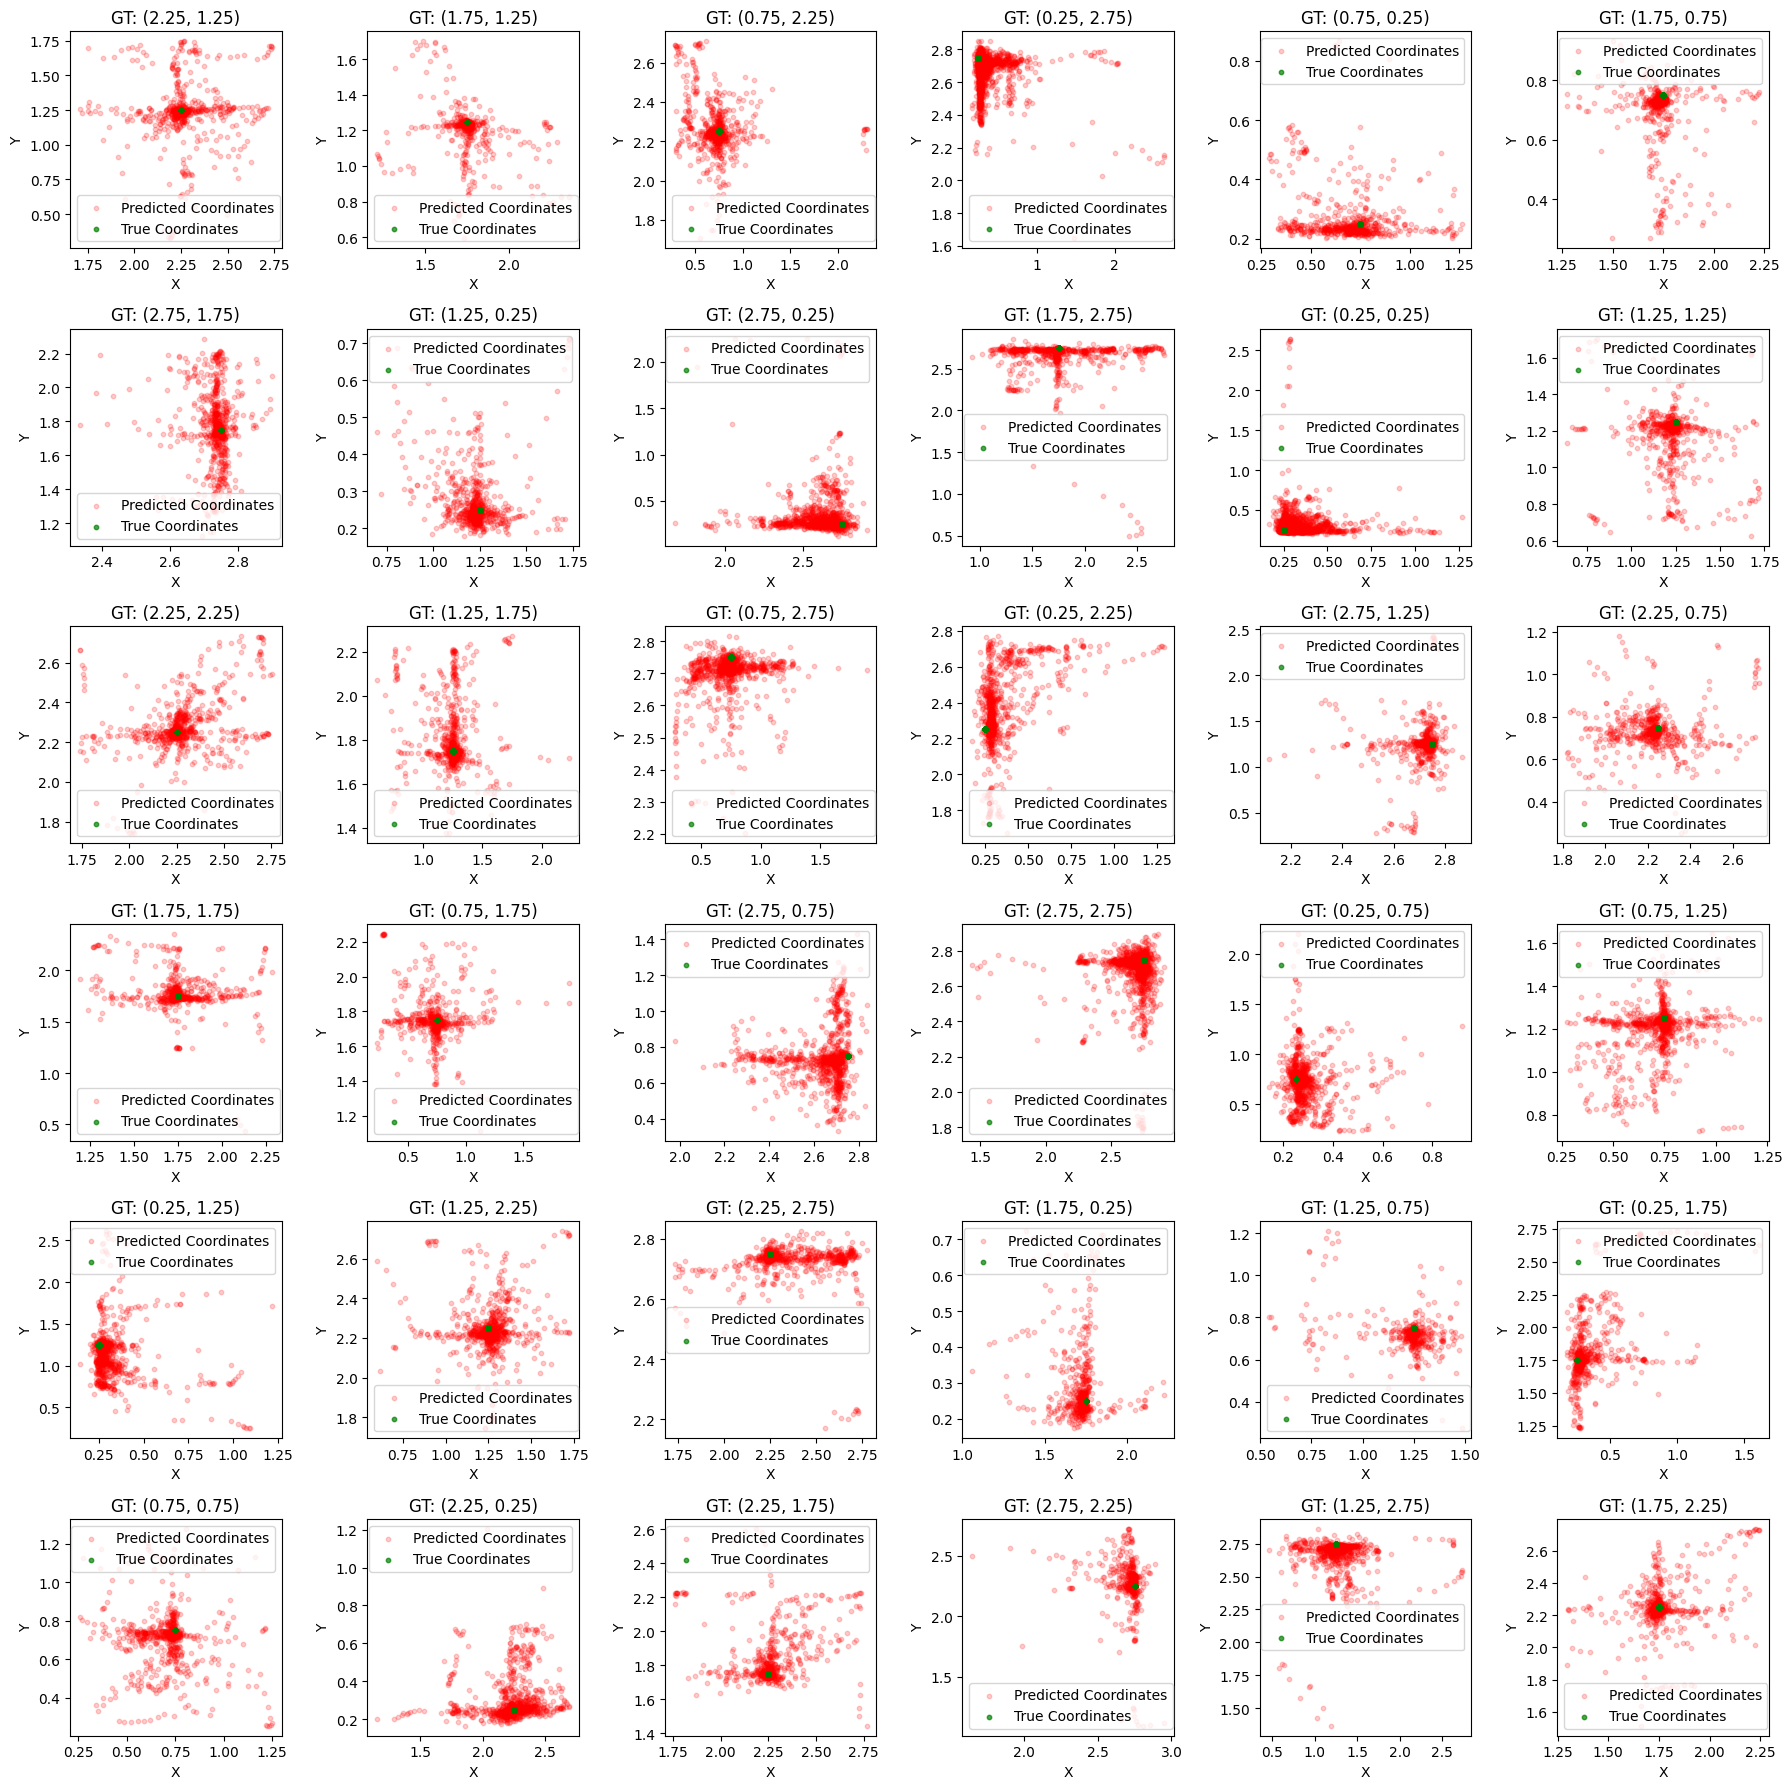

Coordinates saved to coordinates_comparison.csv


In [92]:
import torch.utils.data as data
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Initialize variables
total_distance = 0.0
number_sample = 0
all_true_coords, all_predicted_coords = [], []
ground_truth_dict = defaultdict(lambda: {"true_coords": [], "predicted_coords": []})

print_one_time = 0

# Evaluate model
model.eval()
with torch.no_grad():
    for input_sequence, label in test_loader:
        input_sequence = input_sequence.to(device)
        label = label.to(device)  # True labels are sequences of coordinates, shape [batch_size, num_targets, sequence_length]

        # Forward pass
        output = model(input_sequence)  # Predicted coordinates, shape [batch_size, num_targets, sequence_length]

        # Reshape output and label to [batch_size * sequence_length, num_targets]
        batch_size, num_targets, sequence_length = output.shape
        # if print_one_time == 0:
        #     print_one_time = 1
        #     print(label.shape, 'ssdadasd', output.shape)
        
        output = output.permute(0, 2, 1).contiguous().view(-1, num_targets)  # Shape: [batch_size * sequence_length, num_targets]
        label = label.permute(0, 2, 1).contiguous().view(-1, num_targets)    # Same shape as output

        # Calculate distance for x and y coordinates
        for i in range(label.size(0)):  # Iterate over each timestep
            true_values = label[i]  # True coordinates for the current timestep (x, y)
            predicted_values = output[i]  # Predicted coordinates for the current timestep (x, y)

            # Calculate Euclidean distance between true and predicted coordinates
            distance = torch.norm(true_values - predicted_values).item()  # Calculate distance

            total_distance += distance

            # Store true and predicted coordinates for plotting
            all_true_coords.append(true_values.cpu().numpy())
            all_predicted_coords.append(predicted_values.cpu().numpy())

            # Group by true coordinates for plotting later
            ground_truth_dict[(true_values[0].item(), true_values[1].item())]["true_coords"].append(true_values.cpu().numpy())
            ground_truth_dict[(true_values[0].item(), true_values[1].item())]["predicted_coords"].append(predicted_values.cpu().numpy())

        # Count the number of samples (each timestep contributes one sample)
        number_sample += label.size(0)

# Calculate average distance
mean_distance = total_distance / number_sample
print(f'Mean Euclidean distance: {mean_distance:.4f}')

# Plot true vs predicted coordinates for each ground truth using subplot 6x6
fig, axes = plt.subplots(6, 6, figsize=(18, 18))
axes = axes.flatten()  # Flatten the 6x6 grid for easy iteration

for idx, ((true_x, true_y), coords) in enumerate(ground_truth_dict.items()):
    true_coords = np.array(coords["true_coords"])
    predicted_coords = np.array(coords["predicted_coords"])

    ax = axes[idx]
    ax.scatter(predicted_coords[:, 0], predicted_coords[:, 1], label='Predicted Coordinates', color='red', alpha=0.2,s=10)
    ax.scatter(true_coords[:, 0], true_coords[:, 1], label='True Coordinates', color='green', alpha=0.7,s=10)
    ax.set_title(f'GT: ({true_x:.2f}, {true_y:.2f})')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

# Save the true and predicted coordinates to a file for further analysis
coords_file = 'result compare/v4_3/coordinates_comparison.csv'
with open(coords_file, 'w') as file:
    file.write('True_X,True_Y,Predicted_X,Predicted_Y\n')
    for true_coord, pred_coord in zip(all_true_coords, all_predicted_coords):
        file.write(f'{true_coord[0]},{true_coord[1]},{pred_coord[0]},{pred_coord[1]}\n')
print(f'Coordinates saved to {coords_file}')


Function for process testdata
---



In [90]:
# ______________________________Sec1____________________________________________
def calculate_area(signal, threshold=0):
    # Tính phần diện tích dưới đường cong và trục y=threshold
    diff_signal = signal - threshold

    # Tính diện tích sử dụng quy tắc hình thang
    area = torch.sum(torch.abs((diff_signal[:, :-1] + diff_signal[:, 1:]) / 2), dim=1)

    return area

def check_area(signals, threshold=0, area_threshold=1.5):
    # Tính diện tích cho từng sensor
    areas = calculate_area(signals, threshold)

    # # In ra diện tích của từng sensor
    # for i, area in enumerate(areas):
    #     print(f"Diện tích của sensor {i + 1}: {area.item()}")

    # Tính tổng diện tích của 5 sensor
    total_area = torch.sum(areas)
    # print(f"Tổng diện tích: {total_area.item()}")

    # Kiểm tra tổng diện tích có lớn hơn area_threshold không
    return total_area > area_threshold

# # Giả sử tín hiệu đầu vào dạng torch size (1,5,10)
# signals_list = [
#     [2.05,2.05,2.05,2.05,2.03,2.04,2.04,2.04,2.05,2.05],
#     [2.05,2.05,2.06,2.06,2.06,2.08,2.07,2.07,2.07,2.07],
#     [2.05,2.04,2.03,2.05,2.04,2.04,2.04,2.05,2.05,2.05],
#     [2.04,2.04,2.04,2.05,2.07,2.05,2.05,2.05,2.06,2.05],
#     [2.07,2.06,2.05,2.05,2.04,2.06,2.05,2.06,2.06,2.06]
# ]

# # Chuyển đổi signals_list thành tensor PyTorch
# signals = torch.tensor(signals_list, dtype=torch.float32)
# print(signals)
# # Kiểm tra diện tích
# result = check_area(signals)
# print(f"Kết quả: {result}")
# ______________________________Sec2____________________________________________
def is_adjacent(coord1, coord2):
    """Check if two coordinates are adjacent in the 3x3 grid."""
    if coord1 is None or coord2 is None:
        return False
    row_diff = abs(coord1[0] - coord2[0])
    col_diff = abs(coord1[1] - coord2[1])
    return row_diff <= 1 and col_diff <= 1

import numpy as np

def correct_labels(coordinates):
    """Correct the sequence of coordinates if they are not adjacent."""
    # Chuyển đổi coordinates thành mảng numpy để dễ thao tác
    coordinates = np.array(coordinates)

    corrected_y1 = coordinates[:, 0].copy()
    corrected_y2 = coordinates[:, 1].copy()
    previous_coords = None

    # First pass: fix non-adjacent coordinates
    for i, (y1, y2) in enumerate(zip(coordinates[:, 0], coordinates[:, 1])):
        if y1 == 0 and y2 == 0:
            continue

        current_coords = (y1, y2)  # y1 và y2 đã là tọa độ
        if previous_coords and not is_adjacent(previous_coords, current_coords):
            corrected_y1[i], corrected_y2[i] = corrected_y1[i-1], corrected_y2[i-1]
        previous_coords = current_coords if (y1 != 0 or y2 != 0) else previous_coords

    # Trả về danh sách các tọa độ (y1, y2) đã được điều chỉnh
    return list(zip(corrected_y1.tolist(), corrected_y2.tolist()))




def process_labels(correct_labels):
    """Process labels by replacing (0, 0) with the last non-(0, 0) label."""
    processed_labels = []
    waiting_zero = 0

    for label in correct_labels:
        if label == (0, 0):
            if len(processed_labels) > 0 and processed_labels[-1] != (0, 0):
                processed_labels.append(processed_labels[-1])
            else:
                waiting_zero += 1
        else:
            if waiting_zero > 0:
                # Thay thế tất cả các nhãn (0, 0) đã chờ bằng nhãn không phải (0, 0) cuối cùng
                processed_labels.extend([label] * (waiting_zero + 1))
                waiting_zero = 0
            else:
                processed_labels.append(label)

    return processed_labels


# ______________________________Sec3____________________________________________

# Hàm vẽ đường đi từ danh sách tọa độ
def plot_path(coordinates):
    # Tách tọa độ x và y từ danh sách tọa độ
    x_coords, y_coords = zip(*coordinates)
    
    # Vẽ đường đi
    plt.plot(x_coords, y_coords, marker='o', linestyle='-')
    
    # Đặt tiêu đề và nhãn trục
    plt.title('Đường đi')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')
    
    # Hiển thị đồ thị
    plt.grid(True)
    plt.show()
    
# Hàm vẽ đường đi từ danh sách tọa độ

# Danh sách màu sắc
colors = ['red', 'blue', 'yellow', 'green', 'orange', 'purple', 'cyan', 'magenta']

def mul_plot_path(coordinates):
    if not coordinates:
        print("Danh sách tọa độ trống!")
        return
    
    # Kiểm tra xem có một hoặc nhiều xâu tọa độ
    if isinstance(coordinates[0], tuple):
        coordinates = [coordinates]  # Nếu chỉ có một xâu tọa độ, chuyển đổi thành danh sách có một phần tử
        
    # Lặp qua từng xâu tọa độ và vẽ
    for i, coord_set in enumerate(coordinates):
        # Tách tọa độ x và y từ danh sách tọa độ
        x_coords, y_coords = zip(*coord_set)
        
        # Chọn màu dựa trên chỉ số
        color = colors[i % len(colors)]  # Sử dụng modulo để quay lại màu nếu có nhiều hơn số màu
        
        # Vẽ đường đi với màu khác nhau cho mỗi xâu tọa độ
        plt.plot(x_coords, y_coords, marker='o', c=color, linestyle='-', alpha=0.5, label=f'Path {i+1}')
    
    # Đặt tiêu đề và nhãn trục
    plt.title('Đường đi')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')
    
    # Hiển thị đồ thị và chú thích
    plt.legend()
    plt.grid(True)
    plt.axis([0,3,0,3])
    plt.show()
    
# Hàm vẽ từng điểm từ danh sách tọa độ
def mul_plot_points(coordinates):
    if not coordinates:
        print("Danh sách tọa độ trống!")
        return
    
    # Kiểm tra xem có một hoặc nhiều xâu tọa độ
    if isinstance(coordinates[0], tuple):
        coordinates = [coordinates]  # Nếu chỉ có một xâu tọa độ, chuyển đổi thành danh sách có một phần tử
    
    # Lặp qua từng xâu tọa độ và vẽ từng điểm
    for i, coord_set in enumerate(coordinates):
        # Tách tọa độ x và y từ danh sách tọa độ
        x_coords, y_coords = zip(*coord_set)

        # Chọn màu dựa trên chỉ số
        color = colors[i % len(colors)]  # Sử dụng modulo để quay lại màu nếu có nhiều hơn số màu
        
        # Vẽ các điểm với màu khác nhau cho mỗi xâu tọa độ
        plt.scatter(x_coords, y_coords, s=10, c=color, marker='o', alpha=0.3, label=f'Points {i+1}')
    
    # Đặt tiêu đề và nhãn trục
    plt.title('Các điểm tọa độ')
    plt.xlabel('Tọa độ x')
    plt.ylabel('Tọa độ y')
    
    # Hiển thị đồ thị và chú thích
    plt.legend()
    plt.grid(True)
    plt.axis([0, 3, 0, 3])  # Bạn có thể thay đổi giới hạn trục nếu cần
    plt.show()


Import test data
---



In [88]:
import pandas as pd
import torch
import ast
import os
import csv

# Đọc dữ liệu từ file CSV vào DataFrame
df = pd.read_csv('Preprocessing_and_analysis_of_the_dataset/data_test_data_v4.csv')

# Khởi tạo danh sách để lưu trữ dữ liệu
x_sc_list = []
y_sc_list = []

for row_index in range(df.shape[0]):
    selected_row = df.iloc[row_index]
    
    # Lấy dữ liệu của các cột 'x1', 'x2', 'x3', 'x4', 'x5' từ hàng đã chọn và chuyển thành mảng numpy
    x_values = [ast.literal_eval(selected_row[col]) for col in ['x1', 'x2', 'x3', 'x4', 'x5']]
    
    # Chuyển đổi mảng numpy thành tensor
    X_test = torch.tensor(x_values, dtype=torch.float32).unsqueeze(0)  # Thêm chiều batch_size
    
    # Lấy dữ liệu của các cột 'y1' và 'y2' và chuyển thành mảng numpy
    y_values = [ast.literal_eval(selected_row['y1']), ast.literal_eval(selected_row['y2'])]
    
    # Chuyển đổi mảng numpy thành tensor
    Y_test = torch.tensor(y_values, dtype=torch.float32).unsqueeze(0)
    
    # Kiểm tra kích thước của tensors
    print("Kích thước của X_test của kịch bản", row_index + 1, ":", X_test.shape)
    print("Kích thước của Y_test của kịch bản", row_index + 1, ":", Y_test.shape)
    
    x_sc_list.append(X_test)
    y_sc_list.append(Y_test)

Kích thước của X_test của kịch bản 1 : torch.Size([1, 5, 2073])
Kích thước của Y_test của kịch bản 1 : torch.Size([1, 2, 2073])
Kích thước của X_test của kịch bản 2 : torch.Size([1, 5, 1743])
Kích thước của Y_test của kịch bản 2 : torch.Size([1, 2, 1743])
Kích thước của X_test của kịch bản 3 : torch.Size([1, 5, 3367])
Kích thước của Y_test của kịch bản 3 : torch.Size([1, 2, 3367])
Kích thước của X_test của kịch bản 4 : torch.Size([1, 5, 3877])
Kích thước của Y_test của kịch bản 4 : torch.Size([1, 2, 3877])


Predict and visual testdata (All scenarios)
---



Kịch bản 1
Data written to ./ket_qua_test_v4/output_kich_ban_1.csv
Khoảng cách trung bình: 0.09125719622445445


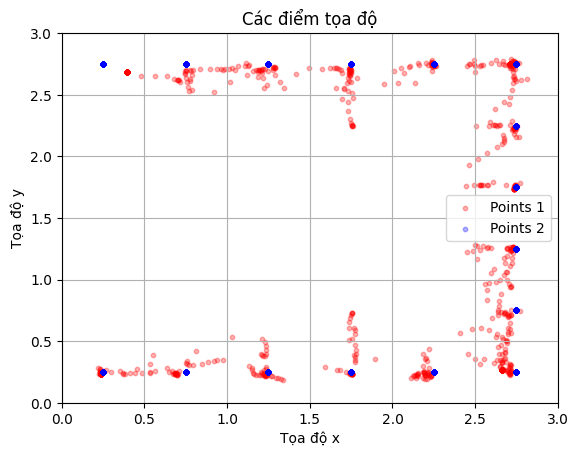

Kịch bản 2
Data written to ./ket_qua_test_v4/output_kich_ban_2.csv
Khoảng cách trung bình: 0.3807326442888436


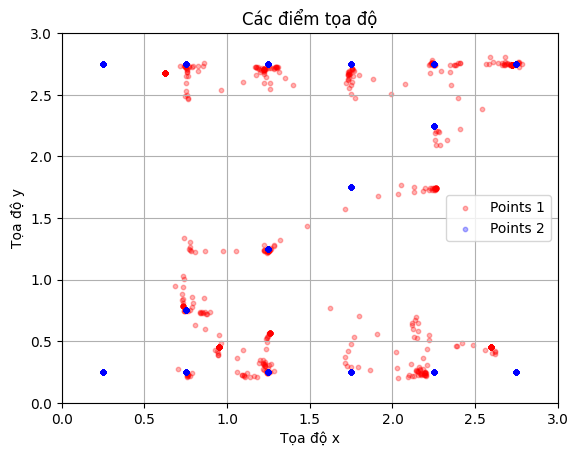

Kịch bản 3
Data written to ./ket_qua_test_v4/output_kich_ban_3.csv
Khoảng cách trung bình: 0.06200969270203091


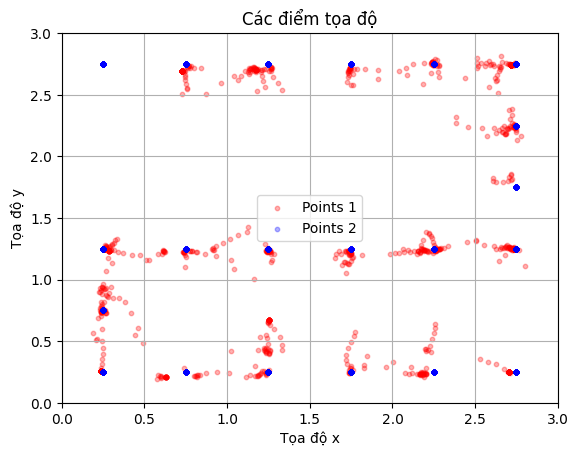

Kịch bản 4
Data written to ./ket_qua_test_v4/output_kich_ban_4.csv
Khoảng cách trung bình: 0.3489639414206179


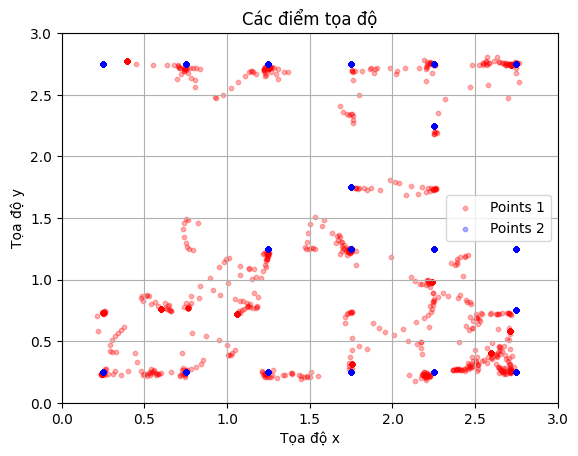

In [91]:
# Ví dụ về window_size nếu cần
window_size = 10

#chuyen sang che do danh gia
model.eval()

# Chọn kịch bản
for sc_index in range(len(y_sc_list)):
    print('Kịch bản', sc_index + 1)
    X_test = x_sc_list[sc_index]
    Y_test = y_sc_list[sc_index]
    
    # Số lượng cửa sổ có thể tạo ra từ dữ liệu test
    num_windows = X_test.shape[2] // window_size
    window_residual = X_test.shape[2] % window_size
    if window_residual:
        num_windows += 1
    
    best_threshold = 3.5
    
    predictions = []
    for sample in X_test:
        sample_windows = []
        for i in range(num_windows):
            window = sample[:, i * window_size: (i + 1) * window_size].unsqueeze(0)
            check = check_area(window[0], area_threshold=best_threshold)
            if check:
                model.eval()
                with torch.no_grad():
                    output = model(window.to(device))
                # Dự đoán cho y1 và y2
                predicted_values = output.squeeze(0).permute(1,0)  # Kích thước [2, 10]
                for t in range(predicted_values.shape[0]):  # Duyệt qua từng timestep
                    y1, y2 = predicted_values[t].tolist()  # Lấy tọa độ cho timestep t
                    sample_windows.append((y1, y2))  # Thêm tuple (y1, y2)
            else:
                sample_windows.extend([(0, 0)] * window_size)  # Dự đoán mặc định
        predictions.append(sample_windows)

    # Duyệt qua kết quả dự đoán
    prediction_raw=predictions[0]
    corrected_labels = correct_labels(prediction_raw)  # Điều chỉnh lại nhãn nếu cần
    processed_labels = process_labels(corrected_labels)
    # Giả sử Y_test có kích thước (1, 2) và bạn cần truy cập vào y1 và y2
    y1_ground_truth = [x for x in Y_test[0][0].tolist()]  # Lấy giá trị y1
    y2_ground_truth = [x for x in Y_test[0][1].tolist()]  # Lấy giá trị y2
    
    # Tạo một danh sách chứa tọa độ (y1, y2) từ các giá trị y1 và y2
    int_list = list(zip(y1_ground_truth, y2_ground_truth))
    
    # Trim và ghi dữ liệu ra file như trước
    min_length = len(int_list)
    trimmed_prediction_raw = prediction_raw[:min_length]
    trimmed_corrected_labels = corrected_labels[:min_length]
    trimmed_processed_labels = processed_labels[:min_length]

    # Specify the file path
    file_path = f'./result compare/v4/ket_qua_test_v4/output_kich_ban_{sc_index + 1}.csv'
    
    # Create the directory if it doesn't exist
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    # Open the file in write mode
    with open(file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        writer.writerow(['Corrected Labels', 'Processed Labels', 'Ground', 'Raw'])
        
        # Write the data rows
        for c_label, p_label, i_val, r_val in zip(trimmed_corrected_labels, trimmed_processed_labels, int_list, trimmed_prediction_raw):
            writer.writerow([c_label, p_label, i_val, r_val])
    
    print(f"Data written to {file_path}")

    # Chuyển đổi các nhãn từ danh sách 1D sang danh sách tọa độ 2D (x, y)
    # y_true_xy = compute_group_coordinates(most_frequent_in_sliding_window(int_list, k=60, s=60,padding=0), area, k=1)
    y_true_xy = int_list
    y_pred_xy = trimmed_processed_labels
    
    # Tính khoảng cách Euclidean giữa các cặp tọa độ và tính khoảng cách trung bình
    distances = [np.linalg.norm(np.array(true_xy) - np.array(pred_xy)) for true_xy, pred_xy in zip(y_true_xy, y_pred_xy)]
    mean_distance = np.mean(distances)
    
    print("Khoảng cách trung bình:", mean_distance)
    
    # Vẽ đường đi từ danh sách tọa độ
    mul_plot_points([y_pred_xy,y_true_xy])